# 📊 RephraseBot Activity Report

This notebook generates comprehensive activity reports for the RephraseBot (TweetRephraserBot).

**Features:**
- Date selection (today, yesterday, or specific date)
- Time range filtering (EST timezone)
- User activity statistics
- Request analytics
- Performance metrics
- X/Twitter link tracking
- Similarity score analysis

## 📅 Date Selection

Enter the date you want to analyze. Supports:
- `today` or `now` - Current date
- `yesterday` - Previous day
- Specific date formats: `YYYY-MM-DD`, `MM/DD/YYYY`, `DD-MM-YYYY`, `Jan 26, 2026`, etc.

In [53]:
import os
import pandas as pd
from datetime import datetime, timedelta
from dateutil import parser
import pytz
from supabase import create_client, Client
from typing import Optional, Tuple
from dotenv import load_dotenv
import warnings
warnings.filterwarnings('ignore')

# Load environment variables from .env file
load_dotenv()

# Configuration
SUPABASE_URL = os.getenv("SUPABASE_URL")
SUPABASE_KEY = os.getenv("SUPABASE_KEY")

if not SUPABASE_URL or not SUPABASE_KEY:
    raise ValueError("Please set SUPABASE_URL and SUPABASE_KEY in .env file or environment variables")

# Initialize Supabase client
supabase: Client = create_client(SUPABASE_URL, SUPABASE_KEY)

# Timezone setup
UTC = pytz.UTC
EST = pytz.timezone('US/Eastern')  # Handles DST automatically

def parse_date_input(date_input: str) -> datetime:
    """Parse various date input formats"""
    date_input = date_input.strip().lower()
    
    if date_input in ['today', 'now']:
        return datetime.now(EST).replace(hour=0, minute=0, second=0, microsecond=0)
    elif date_input == 'yesterday':
        return (datetime.now(EST) - timedelta(days=1)).replace(hour=0, minute=0, second=0, microsecond=0)
    else:
        try:
            # Try parsing with dateutil (handles many formats)
            parsed = parser.parse(date_input)
            # If no timezone, assume EST
            if parsed.tzinfo is None:
                parsed = EST.localize(parsed)
            # Normalize to start of day in EST
            return parsed.replace(hour=0, minute=0, second=0, microsecond=0)
        except Exception as e:
            raise ValueError(f"Could not parse date: {date_input}. Error: {e}")

# DATE INPUT - Modify this value
DATE_INPUT = "today"  # Change to: "today", "yesterday", "2026-01-26", "01/26/2026", etc.

target_date_est = parse_date_input(DATE_INPUT)
print(f"📅 Target Date (EST): {target_date_est.strftime('%Y-%m-%d %I:%M %p %Z')}")
print(f"   UTC equivalent: {target_date_est.astimezone(UTC).strftime('%Y-%m-%d %H:%M:%S UTC')}")

📅 Target Date (EST): 2026-02-05 12:00 AM EST
   UTC equivalent: 2026-02-05 05:00:00 UTC


## ⏰ Time Range Selection (EST)

Enter the time range for analysis. Leave empty for full day.

**Formats supported:**
- `2pm to 4pm`
- `14:00 to 16:00`
- `2:00 PM to 4:00 PM`
- `14:00-16:00`
- Leave empty for full day (00:00 to 23:59)

In [54]:
import re

def parse_time_range(time_input: str, base_date: datetime) -> Tuple[datetime, datetime]:
    """Parse time range input and return start/end datetimes in EST"""
    if not time_input or not time_input.strip():
        # Full day
        start = base_date.replace(hour=0, minute=0, second=0, microsecond=0)
        end = base_date.replace(hour=23, minute=59, second=59, microsecond=999999)
        return start, end
    
    time_input = time_input.strip().lower()
    
    # Try to extract two times
    # Patterns: "2pm to 4pm", "14:00 to 16:00", "2:00 PM-4:00 PM", etc.
    patterns = [
        r'(\d{1,2})(?::(\d{2}))?\s*(am|pm)?\s*(?:to|-)\s*(\d{1,2})(?::(\d{2}))?\s*(am|pm)?',
        r'(\d{1,2}):(\d{2})\s*(?:to|-)\s*(\d{1,2}):(\d{2})',
    ]
    
    start_time = None
    end_time = None
    
    for pattern in patterns:
        match = re.search(pattern, time_input)
        if match:
            groups = match.groups()
            
            # Parse first time
            if len(groups) >= 3:
                hour1 = int(groups[0])
                minute1 = int(groups[1]) if groups[1] else 0
                ampm1 = groups[2].lower() if groups[2] else None
                
                if ampm1 == 'pm' and hour1 != 12:
                    hour1 += 12
                elif ampm1 == 'am' and hour1 == 12:
                    hour1 = 0
                
                start_time = (hour1, minute1)
                
                # Parse second time
                if len(groups) >= 6:
                    hour2 = int(groups[3])
                    minute2 = int(groups[4]) if groups[4] else 0
                    ampm2 = groups[5].lower() if groups[5] else None
                    
                    if ampm2 == 'pm' and hour2 != 12:
                        hour2 += 12
                    elif ampm2 == 'am' and hour2 == 12:
                        hour2 = 0
                    
                    end_time = (hour2, minute2)
            
            break
    
    if start_time is None or end_time is None:
        raise ValueError(f"Could not parse time range: {time_input}")
    
    start_dt = base_date.replace(hour=start_time[0], minute=start_time[1], second=0, microsecond=0)
    end_dt = base_date.replace(hour=end_time[0], minute=end_time[1], second=59, microsecond=999999)
    
    return start_dt, end_dt

# TIME RANGE INPUT - Modify this value
TIME_RANGE_INPUT = ""  # Empty for full day, or "2pm to 4pm", "14:00 to 16:00", etc.

start_time_est, end_time_est = parse_time_range(TIME_RANGE_INPUT, target_date_est)

print(f"⏰ Time Range (EST): {start_time_est.strftime('%I:%M %p')} to {end_time_est.strftime('%I:%M %p')}")
print(f"   UTC equivalent: {start_time_est.astimezone(UTC).strftime('%Y-%m-%d %H:%M:%S')} to {end_time_est.astimezone(UTC).strftime('%Y-%m-%d %H:%M:%S')}")

# Convert to UTC for database queries
start_time_utc = start_time_est.astimezone(UTC)
end_time_utc = end_time_est.astimezone(UTC)

print(f"\n📊 Querying database for activity between:")
print(f"   EST: {start_time_est.strftime('%Y-%m-%d %I:%M %p')} - {end_time_est.strftime('%I:%M %p')}")
print(f"   UTC: {start_time_utc.strftime('%Y-%m-%d %H:%M:%S')} - {end_time_utc.strftime('%H:%M:%S')}")

⏰ Time Range (EST): 12:00 AM to 11:59 PM
   UTC equivalent: 2026-02-05 05:00:00 to 2026-02-06 04:59:59

📊 Querying database for activity between:
   EST: 2026-02-05 12:00 AM - 11:59 PM
   UTC: 2026-02-05 05:00:00 - 04:59:59


## 🔍 Database Table Check

Before fetching data, let's verify the required tables exist in your Supabase database.

In [55]:
# Check if required tables exist
print("🔍 Checking database tables...\n")

required_tables = ["activity_logs", "users"]
existing_tables = []
missing_tables = []

for table_name in required_tables:
    try:
        # Try a simple query to check if table exists
        # Use appropriate column for each table (users has user_id, activity_logs has id)
        if table_name == "users":
            result = supabase.table(table_name).select("user_id").limit(1).execute()
        else:
            result = supabase.table(table_name).select("id").limit(1).execute()
        existing_tables.append(table_name)
        print(f"✅ Table '{table_name}' exists")
    except Exception as e:
        error_msg = str(e)
        if "PGRST205" in error_msg or "not found" in error_msg.lower():
            missing_tables.append(table_name)
            print(f"❌ Table '{table_name}' NOT FOUND")
        else:
            # Table exists but query failed for another reason
            existing_tables.append(table_name)
            print(f"⚠️  Table '{table_name}' exists but query failed: {error_msg[:100]}")

if missing_tables:
    print(f"\n⚠️  MISSING TABLES: {', '.join(missing_tables)}")
    print("\n📝 Please ensure these tables exist in your Supabase database.")
else:
    print("\n✅ All required tables exist! Proceeding with data fetch...")
    print("   Note: activity_logs will be filtered by ='tweet' to show only RephraseBot data")

🔍 Checking database tables...

✅ Table 'activity_logs' exists
✅ Table 'users' exists

✅ All required tables exist! Proceeding with data fetch...
   Note: activity_logs will be filtered by ='tweet' to show only RephraseBot data


## 📥 Fetching Data from Database

In [56]:
# Fetch activity logs
print("Fetching activity logs...")
# Note: activity_logs table (separate table for RephraseBot)
try:
    activity_logs = supabase.table("activity_logs")\
        .select("*")\
        .gte("timestamp", start_time_utc.isoformat())\
        .lte("timestamp", end_time_utc.isoformat())\
        .execute()
    print(f"✅ Found {len(activity_logs.data)} activity log entries (='tweet')")
except Exception as e:
    error_msg = str(e)
    if "activity_logs" in error_msg and "email_activity_logs" in error_msg.lower():
        print("⚠️ ERROR: Table 'activity_logs' not found in database.")
        print("   The table might not exist yet or might be named differently.")
        print("   Please ensure the table exists in Supabase with the name 'activity_logs'")
        print("   Or update the table name in this notebook if using a different name.")
        raise
    else:
        raise

# Fetch all users (for new user detection)
print("\nFetching user data...")
try:
    all_users = supabase.table("users")\
        .select("*")\
        .execute()
    print(f"✅ Found {len(all_users.data)} total users in database")
except Exception as e:
    error_msg = str(e)
    if "users" in error_msg:
        print("⚠️ ERROR: Table 'users' not found in database.")
        print("   The table might not exist yet or might be named differently.")
        print("   Please ensure the table exists in Supabase with the name 'users'")
        print("   Or update the table name in this notebook if using a different name.")
        raise
    else:
        raise

# Convert to DataFrames
df_logs = pd.DataFrame(activity_logs.data)
df_users = pd.DataFrame(all_users.data)

if len(df_logs) > 0:
    # Convert timestamp to datetime and then to EST
    # Parse timestamp - handle both timezone-aware and timezone-naive
    df_logs['timestamp'] = pd.to_datetime(df_logs['timestamp'])
    
    # Ensure timestamp is UTC-aware
    if df_logs['timestamp'].dt.tz is None:
        # Timezone-naive, localize to UTC
        df_logs['timestamp_utc'] = df_logs['timestamp'].dt.tz_localize('UTC')
    else:
        # Already timezone-aware, convert to UTC
        df_logs['timestamp_utc'] = df_logs['timestamp'].dt.tz_convert('UTC')
    
    # Convert to EST
    df_logs['timestamp_est'] = df_logs['timestamp_utc'].dt.tz_convert('US/Eastern')
    df_logs['hour_est'] = df_logs['timestamp_est'].dt.hour
    df_logs['date_est'] = df_logs['timestamp_est'].dt.date
    
    print(f"\n📈 Data Summary:")
    print(f"   Total log entries: {len(df_logs)}")
    print(f"   Unique users: {df_logs['user_id'].nunique()}")
    print(f"   Date range: {df_logs['timestamp_est'].min()} to {df_logs['timestamp_est'].max()}")
else:
    print("⚠️ No activity found for the specified time range")

Fetching activity logs...
✅ Found 171 activity log entries (='tweet')

Fetching user data...
✅ Found 356 total users in database

📈 Data Summary:
   Total log entries: 171
   Unique users: 35
   Date range: 2026-02-05 00:19:11.752025-05:00 to 2026-02-05 21:32:33.935108-05:00


## 👥 User Statistics

In [57]:
if len(df_logs) == 0:
    print("No data to analyze.")
else:
    # Get all unique user IDs from the time period
    active_user_ids = df_logs['user_id'].unique()
    
    # Find new users (first activity in this time period)
    # Get first activity timestamp for each user in the period
    first_activities = df_logs.groupby('user_id')['timestamp_utc'].min().reset_index()
    first_activities.columns = ['user_id', 'first_activity_utc']
    
    # Check if this is their first activity ever (before this time period)
    new_users = []
    for user_id in active_user_ids:
        user_first_activity = first_activities[first_activities['user_id'] == user_id]['first_activity_utc'].iloc[0]
        
        # Check if there's any activity before this time period
        earlier_activity = supabase.table("activity_logs")\
            .select("timestamp")\
            .eq("user_id", int(user_id))\
            .lt("timestamp", start_time_utc.isoformat())\
            .limit(1)\
            .execute()
        
        if len(earlier_activity.data) == 0:
            new_users.append(user_id)
    
    # Get user details
    user_stats = df_logs.groupby('user_id').agg({
        'action_type': 'count',
        'timestamp_est': ['min', 'max'],
        'response_time_ms': 'mean'
    }).reset_index()
    user_stats.columns = ['user_id', 'total_requests', 'first_request_est', 'last_request_est', 'avg_response_time_ms']
    
    # Merge with user info
    if len(df_users) > 0:
        user_stats = user_stats.merge(
            df_users[['user_id', 'first_name', 'last_name', 'username', 'is_pro', 'pro_expires_at', 'trial_ends_at']],
            on='user_id',
            how='left'
        )
        # Create display name: show username, first_name, last_name (only non-null values)
        def create_display_name(row):
            parts = []
            if pd.notna(row.get('username')) and row.get('username'):
                parts.append(f"@{row['username']}")
            if pd.notna(row.get('first_name')) and row.get('first_name'):
                parts.append(row['first_name'])
            if pd.notna(row.get('last_name')) and row.get('last_name'):
                parts.append(row['last_name'])
            
            if parts:
                return " ".join(parts)
            else:
                return f"User {int(row['user_id'])}"
        
        user_stats['display_name'] = user_stats.apply(create_display_name, axis=1)
        
        # Create identifier: prefer username, fallback to user_id
        def create_identifier(row):
            if pd.notna(row.get('username')) and row.get('username'):
                return f"@{row['username']}"
            else:
                return f"ID: {int(row['user_id'])}"
        
        user_stats['identifier'] = user_stats.apply(create_identifier, axis=1)
    else:
        user_stats['display_name'] = user_stats['user_id'].apply(lambda x: f"User {x}")
    
    user_stats['is_new_user'] = user_stats['user_id'].isin(new_users)
    
    print(f"\n{'='*70}")
    print(f"👥 USER STATISTICS")
    print(f"{'='*70}")
    print(f"\n📊 Overview:")
    print(f"   Total unique users: {len(active_user_ids)}")
    print(f"   New users (first time): {len(new_users)}")
    print(f"   Returning users: {len(active_user_ids) - len(new_users)}")
    
    # Sort by requests for ranking
    user_stats_sorted = user_stats.sort_values('total_requests', ascending=False).reset_index(drop=True)
    user_stats_sorted['rank'] = range(1, len(user_stats_sorted) + 1)
    
    # New users list with rankings
    if len(new_users) > 0:
        print(f"\n🆕 NEW USERS ({len(new_users)}):")
        new_user_df = user_stats_sorted[user_stats_sorted['is_new_user']].copy()
        for rank, (idx, row) in enumerate(new_user_df.iterrows(), 1):
            pro_status = "💎 PRO" if row.get('is_pro') else "🆓 FREE"
            print(f"   #{rank:2d} {pro_status} {row['display_name']} ({row['identifier']}) - {int(row['total_requests'])} requests")
    else:
        print(f"\n🆕 NEW USERS: None")
    
    # All active users with rankings
    print(f"\n👤 ALL ACTIVE USERS - RANKED BY REQUESTS ({len(user_stats_sorted)}):")
    print(f"   {'Rank':<6} {'Status':<20} {'User':<40} {'Requests':>8}")
    print(f"   {'-'*6} {'-'*20} {'-'*40} {'-'*8}")
    for idx, row in user_stats_sorted.iterrows():
        status = "🆕 NEW" if row['is_new_user'] else "🔄 RETURNING"
        pro_status = "💎 PRO" if row.get('is_pro') else "🆓 FREE"
        rank = int(row['rank'])
        print(f"   #{rank:<5} {status} {pro_status:<12} {row['display_name']:<40} {int(row['total_requests']):>8}")
    
    # Top users by requests (cleaner format)
    print(f"\n🏆 TOP 10 USERS BY REQUESTS:")
    top_users = user_stats_sorted.head(10)
    for idx, row in top_users.iterrows():
        rank = int(row['rank'])
        pro_status = "💎 PRO" if row.get('is_pro') else "🆓 FREE"
        print(f"   #{rank:2d} {pro_status} {row['display_name']:<35} ({row['identifier']:<20}) - {int(row['total_requests']):>3d} requests")


👥 USER STATISTICS

📊 Overview:
   Total unique users: 35
   New users (first time): 3
   Returning users: 32

🆕 NEW USERS (3):
   # 1 🆓 FREE @z_sadri_US Zarinaz (@z_sadri_US) - 4 requests
   # 2 🆓 FREE @Yaknise ۹۶۱۸۵ cardel (@Yaknise) - 3 requests
   # 3 🆓 FREE Morteza (ID: 107274361) - 1 requests

👤 ALL ACTIVE USERS - RANKED BY REQUESTS (35):
   Rank   Status               User                                     Requests
   ------ -------------------- ---------------------------------------- --------
   #1     🔄 RETURNING 💎 PRO        @ShivaMaleki2020 Shiva                         19
   #2     🔄 RETURNING 🆓 FREE       @faribamoha Fariba Mohammadi                   16
   #3     🔄 RETURNING 🆓 FREE       Sanaz Ashtari                                   9
   #4     🔄 RETURNING 🆓 FREE       @melmel_sh Melika Shahbazi                      9
   #5     🔄 RETURNING 🆓 FREE       @MazyarZ1995 Mazyar Z                           9
   #6     🔄 RETURNING 🆓 FREE       @Paria_faa Paria               

## 📊 Request Statistics

In [58]:
if len(df_logs) == 0:
    print("No data to analyze.")
else:
    print(f"\n{'='*70}")
    print(f"📊 REQUEST STATISTICS")
    print(f"{'='*70}")
    
    # Total requests
    total_requests = len(df_logs)
    print(f"\n📈 Total Requests: {total_requests}")
    
    # Requests by action type
    print(f"\n📋 Requests by Action Type:")
    action_counts = df_logs['action_type'].value_counts()
    for action, count in action_counts.items():
        percentage = (count / total_requests) * 100
        print(f"   {action:25s}: {count:4d} ({percentage:5.1f}%)")
    
    # Success vs Error
    success_count = len(df_logs[df_logs['action_type'] == 'rephrase_success'])
    error_count = len(df_logs[df_logs['action_type'].isin([
        'rephrase_failed', 
        'rate_limited', 
        'telegram_api_error', 
        'bot_blocked_by_user',
        'forwarded_media_error',
        'multiple_links_error',
        'persian_error',
        'invalid_channel'
    ])])
    other_count = total_requests - success_count - error_count
    
    print(f"\n✅ Success Rate:")
    print(f"   Successful rephrases: {success_count} ({(success_count/total_requests*100):.1f}%)")
    print(f"   Errors: {error_count} ({(error_count/total_requests*100):.1f}%)")
    print(f"   Other actions: {other_count} ({(other_count/total_requests*100):.1f}%)")
    
    # Response time statistics
    successful_logs = df_logs[df_logs['action_type'] == 'rephrase_success']
    if len(successful_logs) > 0 and 'response_time_ms' in successful_logs.columns:
        response_times = successful_logs['response_time_ms'].dropna()
        if len(response_times) > 0:
            print(f"\n⏱️  Response Time Statistics (for successful requests):")
            print(f"   Average: {response_times.mean():.0f} ms ({response_times.mean()/1000:.2f} seconds)")
            print(f"   Median:  {response_times.median():.0f} ms ({response_times.median()/1000:.2f} seconds)")
            print(f"   Min:     {response_times.min():.0f} ms ({response_times.min()/1000:.2f} seconds)")
            print(f"   Max:     {response_times.max():.0f} ms ({response_times.max()/1000:.2f} seconds)")
            print(f"   P95:     {response_times.quantile(0.95):.0f} ms ({response_times.quantile(0.95)/1000:.2f} seconds)")
    
    # Message/Tweet length statistics
    if 'original_length' in df_logs.columns:
        original_lengths = df_logs['original_length'].dropna()
        if len(original_lengths) > 0:
            print(f"\n📏 Message Length Statistics:")
            print(f"   Average original length: {original_lengths.mean():.0f} characters")
            print(f"   Median original length:  {original_lengths.median():.0f} characters")
            print(f"   Min length: {original_lengths.min():.0f} characters")
            print(f"   Max length: {original_lengths.max():.0f} characters")
    
    if 'rephrased_length' in df_logs.columns:
        rephrased_lengths = df_logs[df_logs['action_type'] == 'rephrase_success']['rephrased_length'].dropna()
        if len(rephrased_lengths) > 0:
            print(f"   Average rephrased length: {rephrased_lengths.mean():.0f} characters")
            print(f"   Median rephrased length:  {rephrased_lengths.median():.0f} characters")
            
            # Length change
            successful_with_both = df_logs[
                (df_logs['action_type'] == 'rephrase_success') & 
                df_logs['original_length'].notna() & 
                df_logs['rephrased_length'].notna()
            ]
            if len(successful_with_both) > 0:
                length_changes = successful_with_both['rephrased_length'] - successful_with_both['original_length']
                print(f"   Average length change: {length_changes.mean():+.0f} characters")
    
    # Similarity score statistics
    if 'similarity_score' in df_logs.columns:
        similarity_scores = df_logs[df_logs['action_type'] == 'rephrase_success']['similarity_score'].dropna()
        if len(similarity_scores) > 0:
            print(f"\n🎯 Similarity Score Statistics:")
            print(f"   Average similarity: {similarity_scores.mean():.3f}")
            print(f"   Median similarity:  {similarity_scores.median():.3f}")
            print(f"   Min similarity: {similarity_scores.min():.3f}")
            print(f"   Max similarity: {similarity_scores.max():.3f}")
    
    # X/Twitter link tracking
    if 'had_x_link' in df_logs.columns:
        x_link_count = df_logs[df_logs['action_type'] == 'rephrase_success']['had_x_link'].sum()
        total_success = len(df_logs[df_logs['action_type'] == 'rephrase_success'])
        if total_success > 0:
            print(f"\n🔗 X/Twitter Link Tracking:")
            print(f"   Rephrases with X links: {int(x_link_count)} ({x_link_count/total_success*100:.1f}%)")
    
    # Forwarded messages tracking
    if 'was_forwarded' in df_logs.columns:
        forwarded_count = df_logs[df_logs['action_type'] == 'rephrase_success']['was_forwarded'].sum()
        total_success = len(df_logs[df_logs['action_type'] == 'rephrase_success'])
        if total_success > 0:
            print(f"\n📤 Forwarded Messages:")
            print(f"   Rephrases from forwarded messages: {int(forwarded_count)} ({forwarded_count/total_success*100:.1f}%)")
    
    # Error breakdown
    error_logs = df_logs[df_logs['action_type'].isin([
        'rephrase_failed', 
        'rate_limited', 
        'telegram_api_error', 
        'bot_blocked_by_user',
        'forwarded_media_error',
        'multiple_links_error',
        'persian_error',
        'invalid_channel'
    ])]
    if len(error_logs) > 0:
        print(f"\n❌ Error Breakdown:")
        error_types = error_logs['action_type'].value_counts()
        for error_type, count in error_types.items():
            print(f"   {error_type:25s}: {count:4d}")
        
        # Error messages (if available)
        if 'error_message' in error_logs.columns:
            error_messages = error_logs[error_logs['error_message'].notna()]['error_message'].value_counts()
            if len(error_messages) > 0:
                print(f"\n   Most common error messages:")
                for msg, count in error_messages.head(5).items():
                    print(f"      • {msg[:60]}: {count}")


📊 REQUEST STATISTICS

📈 Total Requests: 171

📋 Requests by Action Type:
   rephrase_success         :  141 ( 82.5%)
   rate_limited             :   17 (  9.9%)
   command_start            :   12 (  7.0%)
   invalid_channel          :    1 (  0.6%)

✅ Success Rate:
   Successful rephrases: 141 (82.5%)
   Errors: 18 (10.5%)
   Other actions: 12 (7.0%)

⏱️  Response Time Statistics (for successful requests):
   Average: 3994 ms (3.99 seconds)
   Median:  2430 ms (2.43 seconds)
   Min:     1894 ms (1.89 seconds)
   Max:     28832 ms (28.83 seconds)
   P95:     14126 ms (14.13 seconds)

📏 Message Length Statistics:
   Average original length: 218 characters
   Median original length:  223 characters
   Min length: 155 characters
   Max length: 272 characters
   Average rephrased length: 188 characters
   Median rephrased length:  188 characters
   Average length change: -29 characters

🎯 Similarity Score Statistics:
   Average similarity: 0.306
   Median similarity:  0.295
   Min similarit

## ⏰ Activity Timeline

In [59]:
if len(df_logs) == 0:
    print("No data to analyze.")
else:
    print(f"\n{'='*70}")
    print(f"⏰ ACTIVITY TIMELINE (EST)")
    print(f"{'='*70}")
    
    # Activity by hour
    print(f"\n📊 Activity by Hour (EST):")
    hourly_activity = df_logs.groupby('hour_est').size().reset_index(name='count')
    hourly_activity = hourly_activity.sort_values('hour_est')
    
    max_count = hourly_activity['count'].max()
    
    for _, row in hourly_activity.iterrows():
        hour = int(row['hour_est'])
        count = int(row['count'])
        hour_str = f"{hour:2d}:00"
        bar_length = int((count / max_count) * 50) if max_count > 0 else 0
        bar = "█" * bar_length
        print(f"   {hour_str} EST: {count:4d} requests {bar}")
    
    # Peak hours
    peak_hour = hourly_activity.loc[hourly_activity['count'].idxmax()]
    print(f"\n   🏆 Peak hour: {int(peak_hour['hour_est']):02d}:00 EST with {int(peak_hour['count'])} requests")
    
    # Activity timeline (first and last activity)
    print(f"\n📅 Activity Timeline:")
    print(f"   First activity: {df_logs['timestamp_est'].min().strftime('%Y-%m-%d %I:%M:%S %p %Z')}")
    print(f"   Last activity:  {df_logs['timestamp_est'].max().strftime('%Y-%m-%d %I:%M:%S %p %Z')}")
    
    # Requests per minute (if time range is small)
    time_span = (end_time_est - start_time_est).total_seconds() / 60  # minutes
    if time_span <= 60:  # If less than 1 hour, show per-minute breakdown
        print(f"\n📊 Activity by Minute (EST):")
        df_logs['minute_est'] = df_logs['timestamp_est'].dt.floor('T')
        minute_activity = df_logs.groupby('minute_est').size().reset_index(name='count')
        minute_activity = minute_activity.sort_values('minute_est')
        
        for _, row in minute_activity.iterrows():
            minute = row['minute_est']
            count = int(row['count'])
            print(f"   {minute.strftime('%H:%M')} EST: {count} requests")


⏰ ACTIVITY TIMELINE (EST)

📊 Activity by Hour (EST):
    0:00 EST:   19 requests █████████
    1:00 EST:    3 requests █
    5:00 EST:   10 requests █████
    6:00 EST:    1 requests 
    9:00 EST:    1 requests 
   10:00 EST:    6 requests ███
   11:00 EST:    3 requests █
   13:00 EST:   16 requests ████████
   18:00 EST:    6 requests ███
   20:00 EST:    9 requests ████
   21:00 EST:   97 requests ██████████████████████████████████████████████████

   🏆 Peak hour: 21:00 EST with 97 requests

📅 Activity Timeline:
   First activity: 2026-02-05 12:19:11 AM EST
   Last activity:  2026-02-05 09:32:33 PM EST


## 💎 Pro vs Free Users

In [60]:
if len(df_logs) == 0:
    print("No data to analyze.")
else:
    print(f"\n{'='*70}")
    print(f"💎 PRO vs FREE USERS")
    print(f"{'='*70}")
    
    # Merge with user data to get Pro status
    if len(df_users) > 0:
        df_logs_with_users = df_logs.merge(
            df_users[['user_id', 'is_pro', 'pro_expires_at', 'trial_ends_at']],
            on='user_id',
            how='left'
        )
        
        # Determine Pro status (check expiration dates)
        now_utc = datetime.now(UTC)
        
        def is_pro_active(row):
            if pd.isna(row.get('is_pro')) or not row.get('is_pro'):
                # Check trial
                if pd.notna(row.get('trial_ends_at')):
                    trial_end = pd.to_datetime(row['trial_ends_at'])
                    if trial_end.tz is None:
                        trial_end = UTC.localize(trial_end)
                    return trial_end > now_utc
                return False
            
            # Check Pro expiration
            if pd.isna(row.get('pro_expires_at')):
                return True  # Lifetime Pro
            
            pro_end = pd.to_datetime(row['pro_expires_at'])
            if pro_end.tz is None:
                pro_end = UTC.localize(pro_end)
            return pro_end > now_utc
        
        df_logs_with_users['is_pro_active'] = df_logs_with_users.apply(is_pro_active, axis=1)
        
        # Pro vs Free statistics
        pro_users = df_logs_with_users[df_logs_with_users['is_pro_active'] == True]['user_id'].nunique()
        free_users = df_logs_with_users[df_logs_with_users['is_pro_active'] == False]['user_id'].nunique()
        
        pro_requests = len(df_logs_with_users[df_logs_with_users['is_pro_active'] == True])
        free_requests = len(df_logs_with_users[df_logs_with_users['is_pro_active'] == False])
        
        print(f"\n👥 User Count:")
        print(f"   Pro users:  {pro_users}")
        print(f"   Free users: {free_users}")
        
        print(f"\n📊 Request Count:")
        print(f"   Pro requests:  {pro_requests} ({(pro_requests/len(df_logs)*100):.1f}%)")
        print(f"   Free requests: {free_requests} ({(free_requests/len(df_logs)*100):.1f}%)")
        
        if pro_users > 0:
            avg_pro_requests = pro_requests / pro_users
            print(f"   Average requests per Pro user: {avg_pro_requests:.1f}")
        
        if free_users > 0:
            avg_free_requests = free_requests / free_users
            print(f"   Average requests per Free user: {avg_free_requests:.1f}")
    else:
        print("\n⚠️ User data not available for Pro/Free analysis")


💎 PRO vs FREE USERS

👥 User Count:
   Pro users:  3
   Free users: 32

📊 Request Count:
   Pro requests:  28 (16.4%)
   Free requests: 143 (83.6%)
   Average requests per Pro user: 9.3
   Average requests per Free user: 4.5


## 📈 10-Day Trend Analysis

Visualization of key metrics over the last 10 days:
- New users per day
- Active users per day  
- Number of requests per day

📊 Fetching data for last 10 days...
   Date range: 2026-01-27 to 2026-02-05 EST


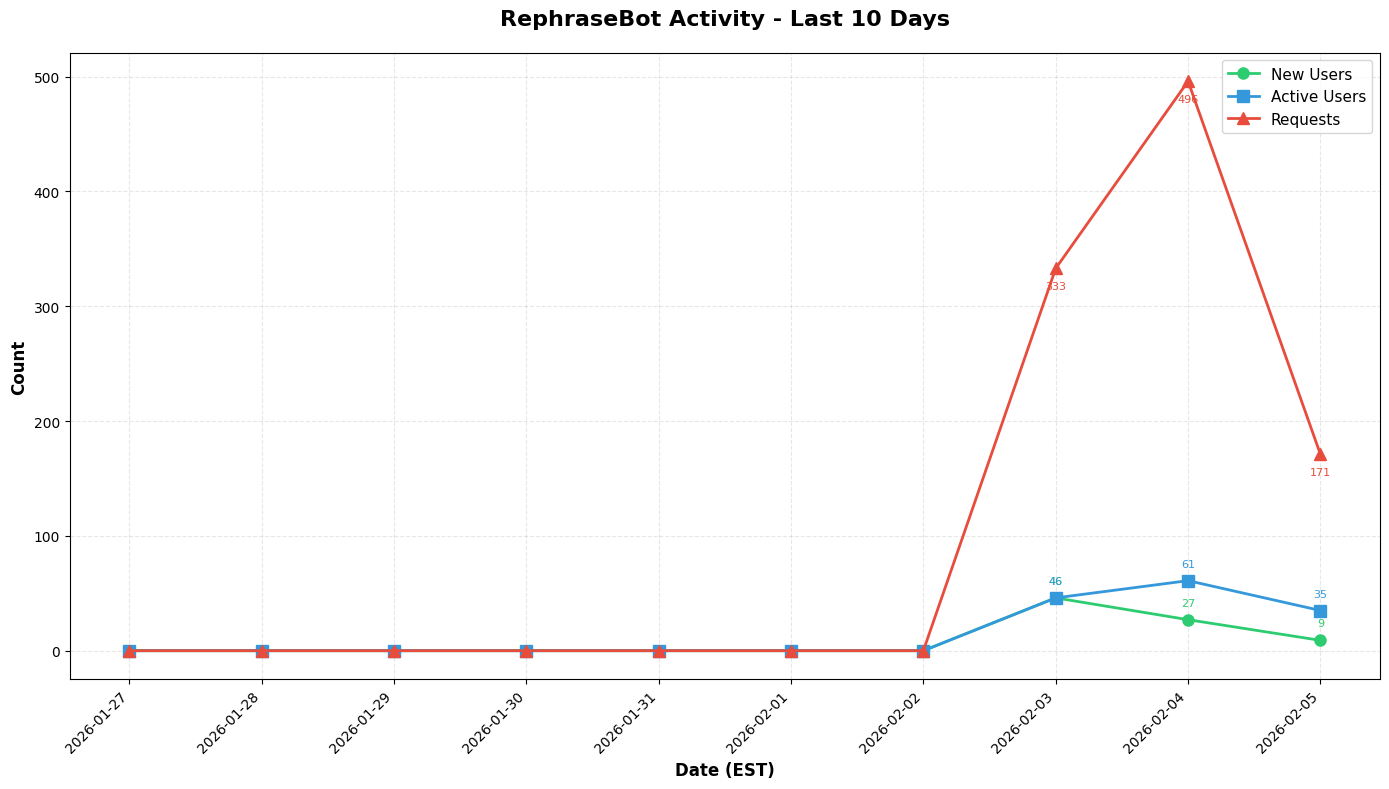


📊 10-DAY SUMMARY TABLE
Date            New Users   Active Users   Requests
------------ ------------ -------------- ----------
2026-01-27              0              0          0
2026-01-28              0              0          0
2026-01-29              0              0          0
2026-01-30              0              0          0
2026-01-31              0              0          0
2026-02-01              0              0          0
2026-02-02              0              0          0
2026-02-03             46             46        333
2026-02-04             27             61        496
2026-02-05              9             35        171
TOTAL                  82             61       1000


In [61]:
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

# Calculate date range for last 10 days
end_date_est = datetime.now(EST).replace(hour=23, minute=59, second=59, microsecond=999999)
start_date_est = (end_date_est - timedelta(days=9)).replace(hour=0, minute=0, second=0, microsecond=0)

# Convert to UTC for database queries
start_date_utc = start_date_est.astimezone(UTC)
end_date_utc = end_date_est.astimezone(UTC)

print(f"📊 Fetching data for last 10 days...")
print(f"   Date range: {start_date_est.strftime('%Y-%m-%d')} to {end_date_est.strftime('%Y-%m-%d')} EST")

# Fetch all activity logs for the last 10 days
all_logs = supabase.table("activity_logs")\
    .select("*")\
    .gte("timestamp", start_date_utc.isoformat())\
    .lte("timestamp", end_date_utc.isoformat())\
    .execute()

df_all_logs = pd.DataFrame(all_logs.data)

if len(df_all_logs) > 0:
    # Convert timestamp to datetime and EST
    df_all_logs['timestamp'] = pd.to_datetime(df_all_logs['timestamp'])
    if df_all_logs['timestamp'].dt.tz is None:
        df_all_logs['timestamp_utc'] = df_all_logs['timestamp'].dt.tz_localize('UTC')
    else:
        df_all_logs['timestamp_utc'] = df_all_logs['timestamp'].dt.tz_convert('UTC')
    df_all_logs['timestamp_est'] = df_all_logs['timestamp_utc'].dt.tz_convert('US/Eastern')
    df_all_logs['date_est'] = df_all_logs['timestamp_est'].dt.date
    
    # Get all users for new user detection
    all_users_data = supabase.table("users").select("*").execute()
    df_all_users = pd.DataFrame(all_users_data.data)
    
    # Calculate metrics for each day
    dates = []
    new_users_count = []
    active_users_count = []
    requests_count = []
    
    for day_offset in range(10):
        current_date_est = (start_date_est + timedelta(days=day_offset)).date()
        dates.append(current_date_est)
        
        # Filter logs for this day
        day_logs = df_all_logs[df_all_logs['date_est'] == current_date_est]
        
        # Number of requests
        requests_count.append(len(day_logs))
        
        # Active users (unique users who made requests)
        active_users_count.append(day_logs['user_id'].nunique() if len(day_logs) > 0 else 0)
        
        # New users (users whose first activity is on this day)
        if len(day_logs) > 0:
            day_user_ids = day_logs['user_id'].unique()
            new_users_day = 0
            
            for user_id in day_user_ids:
                # Check if this user has any activity before this day
                earlier_logs = df_all_logs[
                    (df_all_logs['user_id'] == user_id) & 
                    (df_all_logs['date_est'] < current_date_est)
                ]
                if len(earlier_logs) == 0:
                    new_users_day += 1
            
            new_users_count.append(new_users_day)
        else:
            new_users_count.append(0)
    
    # Create the plot
    plt.figure(figsize=(14, 8))
    
    # Plot three lines
    plt.plot(dates, new_users_count, marker='o', linewidth=2, markersize=8, label='New Users', color='#2ecc71')
    plt.plot(dates, active_users_count, marker='s', linewidth=2, markersize=8, label='Active Users', color='#3498db')
    plt.plot(dates, requests_count, marker='^', linewidth=2, markersize=8, label='Requests', color='#e74c3c')
    
    # Formatting
    plt.xlabel('Date (EST)', fontsize=12, fontweight='bold')
    plt.ylabel('Count', fontsize=12, fontweight='bold')
    plt.title('RephraseBot Activity - Last 10 Days', fontsize=16, fontweight='bold', pad=20)
    plt.legend(fontsize=11, loc='best')
    plt.grid(True, alpha=0.3, linestyle='--')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    
    # Add value labels on points
    for i, (date, new, active, req) in enumerate(zip(dates, new_users_count, active_users_count, requests_count)):
        if new > 0:
            plt.annotate(f'{new}', (date, new), textcoords="offset points", xytext=(0,10), ha='center', fontsize=8, color='#2ecc71')
        if active > 0:
            plt.annotate(f'{active}', (date, active), textcoords="offset points", xytext=(0,10), ha='center', fontsize=8, color='#3498db')
        if req > 0:
            plt.annotate(f'{req}', (date, req), textcoords="offset points", xytext=(0,-15), ha='center', fontsize=8, color='#e74c3c')
    
    plt.show()
    
    # Print summary table
    print(f"\n{'='*70}")
    print(f"📊 10-DAY SUMMARY TABLE")
    print(f"{'='*70}")
    print(f"{'Date':<12} {'New Users':>12} {'Active Users':>14} {'Requests':>10}")
    print(f"{'-'*12} {'-'*12} {'-'*14} {'-'*10}")
    for date, new, active, req in zip(dates, new_users_count, active_users_count, requests_count):
        print(f"{date.strftime('%Y-%m-%d'):<12} {new:>12} {active:>14} {req:>10}")
    print(f"{'='*70}")
    print(f"{'TOTAL':<12} {sum(new_users_count):>12} {max(active_users_count):>14} {sum(requests_count):>10}")
    
else:
    print("⚠️ No data available for the last 10 days")

## 📈 Summary Report

In [62]:
if len(df_logs) == 0:
    print("No data to analyze.")
else:
    print(f"\n{'='*70}")
    print(f"📈 SUMMARY REPORT")
    print(f"{'='*70}")
    print(f"\n📅 Date: {target_date_est.strftime('%Y-%m-%d (%A)')}")
    print(f"⏰ Time Range: {start_time_est.strftime('%I:%M %p')} - {end_time_est.strftime('%I:%M %p')} EST")
    print(f"\n📊 Key Metrics:")
    print(f"   • Total Requests: {len(df_logs)}")
    print(f"   • Unique Users: {df_logs['user_id'].nunique()}")
    
    success_count = len(df_logs[df_logs['action_type'] == 'rephrase_success'])
    print(f"   • Successful Rephrases: {success_count} ({(success_count/len(df_logs)*100):.1f}%)")
    
    if len(new_users) > 0:
        print(f"   • New Users: {len(new_users)}")
    
    if len(df_logs) > 0:
        response_times = df_logs[df_logs['action_type'] == 'rephrase_success']['response_time_ms'].dropna()
        if len(response_times) > 0:
            print(f"   • Avg Response Time: {response_times.mean()/1000:.2f} seconds")
    
    peak_hour_data = df_logs.groupby('hour_est').size()
    if len(peak_hour_data) > 0:
        peak_hour = peak_hour_data.idxmax()
        peak_count = peak_hour_data.max()
        print(f"   • Peak Hour: {int(peak_hour):02d}:00 EST ({peak_count} requests)")
    
    print(f"\n{'='*70}")


📈 SUMMARY REPORT

📅 Date: 2026-02-05 (Thursday)
⏰ Time Range: 12:00 AM - 11:59 PM EST

📊 Key Metrics:
   • Total Requests: 171
   • Unique Users: 35
   • Successful Rephrases: 141 (82.5%)
   • New Users: 3
   • Avg Response Time: 3.99 seconds
   • Peak Hour: 21:00 EST (97 requests)

